<a href="https://colab.research.google.com/github/nakahara11/improve_model/blob/main/model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import zipfile
import os

# ローカルの zip ファイルをアップロード
uploaded = files.upload()  # ここで PC のファイル選択ウィンドウが出る

# zipファイル名を取得（1個だけアップした想定）
zip_filename = list(uploaded.keys())[0]

# 解凍
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('/content/data')

# 解凍先のパスをデータフォルダ
data_dir = '/content/data'  # ここに /battery, /plastic などがある前提


Saving archive_improved.zip to archive_improved.zip


In [2]:
data_dir = '/content/data'

In [3]:
# ✅ ① 必要なライブラリのインポート
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
import json

print("✔ ① ライブラリのインポート完了")

✔ ① ライブラリのインポート完了


In [4]:
import os

# パスの存在チェック
print("📁 存在チェック:", os.path.exists('/content/data'))

# フォルダの中身を表示
if os.path.exists('/content/data'):
    print("📂 中身:")
    print(os.listdir('/content/data'))
else:
    print("❌ パスが見つかりません")


📁 存在チェック: True
📂 中身:
['battery', 'metal', 'organic', 'paper', 'plastic', 'glass']


In [7]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

# 前処理
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# データセット作成
train_dataset = ImageFolder(root=data_dir, transform=transform)

# データローダー
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print("OK!")

OK!


In [8]:
# ✅ ② ヘルパー関数（画像読み込み、モデル定義など）
def load_images_from_folder(folder_path, img_size=(64, 64), target_classes=None):
    images = []
    labels = []
    class_names = []

    sorted_subfolders = sorted(os.listdir(folder_path))
    for class_name in sorted_subfolders:
        if target_classes and class_name not in target_classes:
            continue

        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            if class_name not in class_names:
                class_names.append(class_name)
            label_index = class_names.index(class_name)
            print(f"読み込み中: {class_name}")

            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    try:
                        img_path = os.path.join(class_path, img_name)
                        img = Image.open(img_path).convert('RGB')
                        img = img.resize(img_size)
                        img_array = np.array(img) / 255.0
                        images.append(img_array)
                        labels.append(label_index)
                    except Exception as e:
                        print(f"⚠️ 読み込み失敗: {img_path}, エラー: {e}")

    if not images:
        raise ValueError("画像が読み込めませんでした")

    return np.array(images), np.array(labels), class_names

def create_simple_model(input_shape=(64, 64, 3), num_classes=6):
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred_classes, class_names):
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

print("✔ ② ヘルパー関数の定義完了")

✔ ② ヘルパー関数の定義完了


In [9]:
# ✅ ③ データと保存先パスの定義
data_path = '/content/data'
group_list = group_list = [['battery', 'plastic', 'glass', 'metal', 'paper', 'organic']]

saved_model_path = "model_checkpoint.h5"
class_names_total = ['battery', 'plastic', 'glass', 'metal', 'paper', 'organic']

print("✔ ③ データパスとクラスグループ設定完了")


✔ ③ データパスとクラスグループ設定完了


In [10]:
import os

print("📊 クラスごとの画像枚数:")
for cls in sorted(os.listdir(data_path)):
    cls_path = os.path.join(data_path, cls)
    if os.path.isdir(cls_path):
        num_imgs = len([
            f for f in os.listdir(cls_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        print(f" - {cls}: {num_imgs}枚")

📊 クラスごとの画像枚数:
 - battery: 3875枚
 - glass: 3875枚
 - metal: 3875枚
 - organic: 3875枚
 - paper: 3875枚
 - plastic: 3875枚


In [13]:
import os
import gc
import tensorflow.keras.backend as K
from keras.models import load_model

# ✅ モデル保存パスと再開インデックス
saved_model_path = '/content/models/model_checkpoint.h5'
start_index = 0

# ✅ 既に保存済みモデルがあれば読み込んで続きから再開
if os.path.exists(saved_model_path):
    print("📂 既存モデルを読み込みます...")
    model = load_model(saved_model_path)
    # Determine the last trained group index from the loaded model or a flag
    # For now, let's assume we need to retrain all groups for simplicity
    start_index = 0 # Reset to 0 to retrain from the beginning if needed, or implement logic to find the last trained group
else:
    print("🆕 新しいモデルを作成します...")
    # Load a dummy dataset for model creation to get input shape
    # Load the first group to get the input shape for model creation
    X_dummy, y_dummy, _ = load_images_from_folder(data_path, img_size=(64, 64), target_classes=group_list[0])
    model = create_simple_model(input_shape=X_dummy.shape[1:], num_classes=len(class_names_total))
    del X_dummy, y_dummy
    gc.collect()

# Initialize X_test and y_test outside the loop
X_test = None
y_test = None

# ✅ 学習ループ
for i, group in enumerate(group_list[start_index:], start=start_index):
    print(f"\n=== グループ{i+1}/{len(group_list)}: {group} ===")

    # Load data for the current group
    X, y, current_class_names = load_images_from_folder(data_path, img_size=(64, 64), target_classes=group)

    # Split data
    X_train, X_test_current, y_train, y_test_current = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Assign the last split to X_test and y_test
    X_test = X_test_current
    y_test = y_test_current

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test), # Use the assigned X_test and y_test for validation
        epochs=10,
        batch_size=8,  # 👈 ここでメモリ対策も兼ねておくと安全
        verbose=1
    )

    # Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(saved_model_path), exist_ok=True)
    model.save(saved_model_path)
    print(f"✔ モデル保存完了: {saved_model_path}")

    # メモリ開放 (keep X_test and y_test)
    del X, y, X_train, y_train, X_test_current, y_test_current
    K.clear_session()
    gc.collect()

print("✔ モデルの段階学習完了")

🆕 新しいモデルを作成します...
読み込み中: battery
読み込み中: glass
読み込み中: metal
読み込み中: organic
読み込み中: paper
読み込み中: plastic


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



=== グループ1/1: ['battery', 'plastic', 'glass', 'metal', 'paper', 'organic'] ===
読み込み中: battery
読み込み中: glass
読み込み中: metal
読み込み中: organic
読み込み中: paper
読み込み中: plastic
Epoch 1/10
2325/2325 ━━━━━━━━━━━━━━━━━━━━ 151s 64ms/step - accuracy: 0.4973 - loss: 1.2584 - val_accuracy: 0.6701 - val_loss: 0.8798
Epoch 2/10
2325/2325 ━━━━━━━━━━━━━━━━━━━━ 201s 63ms/step - accuracy: 0.7269 - loss: 0.7298 - val_accuracy: 0.7559 - val_loss: 0.6634
Epoch 3/10
2325/2325 ━━━━━━━━━━━━━━━━━━━━ 214s 68ms/step - accuracy: 0.8360 - loss: 0.4636 - val_accuracy: 0.8047 - val_loss: 0.5622
Epoch 4/10
2325/2325 ━━━━━━━━━━━━━━━━━━━━ 191s 64ms/step - accuracy: 0.8895 - loss: 0.3130 - val_accuracy: 0.8258 - val_loss: 0.5329
Epoch 5/10
2325/2325 ━━━━━━━━━━━━━━━━━━━━ 203s 64ms/step - accuracy: 0.9251 - loss: 0.2183 - val_accuracy: 0.8559 - val_loss: 0.4938
Epoch 6/10
2325/2325 ━━━━━━━━━━━━━━━━━━━━ 199s 63ms/step - accuracy: 0.9435 - loss: 0.1675 - val_accuracy: 0.8563 - val_loss: 0.4827
Epoch 7/10
2325/2325 ━━━━━━━━━━━━━━━━━━

✔ モデル保存完了: /content/models/model_checkpoint.h5
✔ モデルの段階学習完了


In [14]:
import shutil
from google.colab import files

# モデルフォルダを zip に
shutil.make_archive('/content/model_backup', 'zip', '/content/models')

# ダウンロードリンク
files.download('/content/model_backup.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

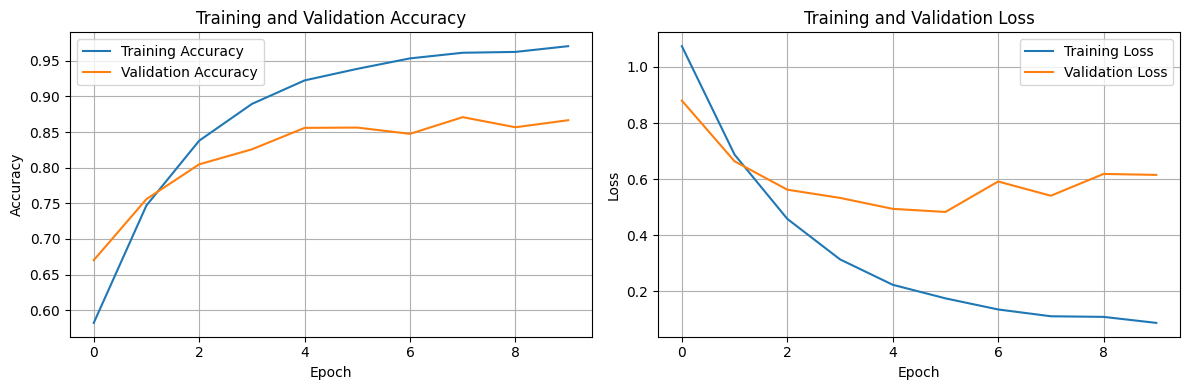

✔ ⑨ 訓練履歴のプロット完了


In [15]:
# ✅ ⑨ 学習曲線の表示
plot_training_history(history)
print("✔ ⑨ 訓練履歴のプロット完了")

In [19]:
# ✅ ⑩ モデルとクラス名の保存
os.makedirs('models', exist_ok=True)
model_save_path = 'models/simple_garbage_model_6class.h5'
model.save(model_save_path)

class_names_path = 'models/class_names_6class.json'
with open(class_names_path, 'w', encoding='utf-8') as f:
    json.dump(class_names_total, f, ensure_ascii=False)

print(f"💾 モデル保存: {model_save_path}")
print(f"💾 クラス名保存: {class_names_path}")
print("✔ ⑩ モデルとクラス名の保存完了")

💾 モデル保存: models/simple_garbage_model_6class.h5
💾 クラス名保存: models/class_names_6class.json
✔ ⑩ モデルとクラス名の保存完了


In [18]:
from google.colab import files

# モデルファイルをダウンロード
files.download('models/simple_garbage_model_6class.h5')

# クラス名ファイルをダウンロード
files.download('models/class_names_6class.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🎯 最終テスト損失: 0.6149
🎯 最終テスト精度: 86.67%
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step

📊 分類レポート:
              precision    recall  f1-score   support

     battery       0.92      0.93      0.92       775
     plastic       0.79      0.86      0.82       775
       glass       0.85      0.81      0.83       775
       metal       0.91      0.94      0.92       775
       paper       0.91      0.82      0.86       775
     organic       0.83      0.83      0.83       775

    accuracy                           0.87      4650
   macro avg       0.87      0.87      0.87      4650
weighted avg       0.87      0.87      0.87      4650


📊 混同行列:


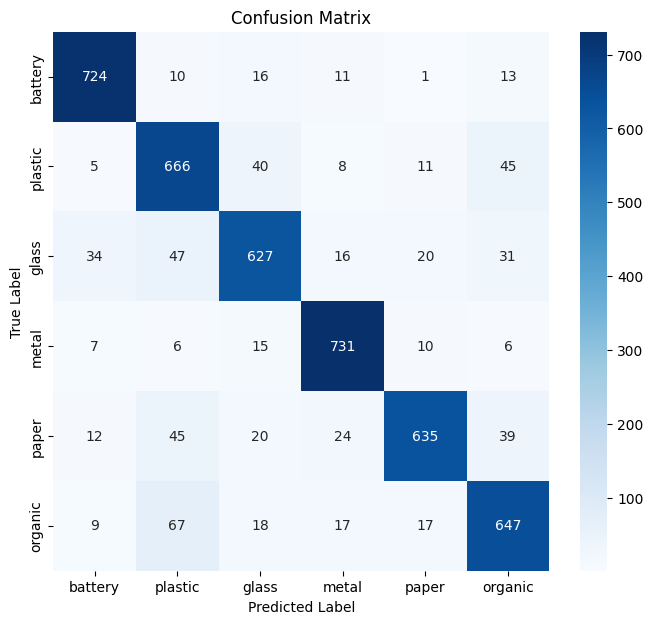

In [21]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report

# ✅ ⑪ テスト評価・混同行列
if X_test is not None and y_test is not None:
    # 評価
    final_loss, final_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"🎯 最終テスト損失: {final_loss:.4f}")
    print(f"🎯 最終テスト精度: {final_accuracy:.2%}")

    # ✅ 予測
    y_pred_probs = model.predict(X_test)
    y_pred_classes = y_pred_probs.argmax(axis=1)

    # クラス名の一致確認
    labels = unique_labels(y_test, y_pred_classes)
    target_names_subset = [class_names_total[i] for i in labels]

    # 分類レポート
    print("\n📊 分類レポート:")
    print(classification_report(y_test, y_pred_classes, labels=labels, target_names=target_names_subset))

    # 混同行列（plot_confusion_matrix が定義されている場合）
    print("\n📊 混同行列:")
    plot_confusion_matrix(y_test, y_pred_classes, target_names_subset)
else:
    print("⚠️ X_test または y_test が未定義です。")
